This notebook compares a genome query neighborhood and plots it side by side with depth (metagenome fraction, number of base pairs) information. 
This plot shows that similarity between neighborhoods is often driven by depth -- things that are more deeply sequenced are more likely to have a higher jaccard similarity with each other.
This plotting scheme was helpful in figuring out that mgx by mgx comparisons weren't the most useful for trying to look at ecotypes vs pathotypes.

In [7]:
setwd("..")

In [8]:
library(readr)
library(ggplot2)
library(dplyr)
library(purrr)
library(aplot)
library(ggpubr)
library(ggExtra)
library(TidyMultiqc)

### metadata

In [10]:
metadata <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  select(library_name, study_accession, diagnosis) %>%
  distinct() %>%
  mutate(diagnosis = factor(diagnosis, levels = c("nonIBD", "CD", "UC")))

### sourmash compare

In [11]:
species_string <- "GCA_000210075.1--s__Bacteroides_xylanisolvens"
acc_string <- "-GCA_000210075.1-"
acc_string2 <- gsub("-", "", acc_string)

In [12]:
# comp <- read_csv(paste0("outputs/sgc_genome_queries_orpheum_species_comp/",
#                         species_string,
#                         "_comp.csv"))
# colnames(comp) <- gsub(acc_string, "", colnames(comp))
#rownames(comp) <- colnames(comp)
#comp <- as.matrix(comp)

In [14]:
comp <- read_csv(paste0("outputs/sgc_genome_queries_orpheum_species_comp/",
                              species_string,
                              "_clustered.csv"), show_col_types = F)

In [15]:
colnames(comp) <- gsub(acc_string, "", rev(colnames(comp))) # sourmash 4.2.2 has a bug; reverse colnames (see sourmash:#1605)
rownames(comp) <- colnames(comp)
comp <- as.matrix(comp)

Warning message:
“Setting row names on a tibble is deprecated.”


In [16]:
# reorder metadata to match order of comp
metadata <- metadata[order(match(metadata$library_name, rownames(comp))), ]

In [17]:
# annot_col_df <- metadata %>%
#   tibble::column_to_rownames("library_name") %>%
#   select(-study_accession)
# annot_row_df <- metadata %>%
#   tibble::column_to_rownames("library_name") %>%
#   select(-study_accession)
# breaklist <- seq(0, 1, by = .05)
# comp_plt <- pheatmap::pheatmap(comp, fontsize = 7, 
#                    border_color = NA, 
#                    breaks = breaklist,
#                    cluster_rows = F,  # use clustering of sourmash
#                    cluster_cols = F,  # use clustering of sourmash
#                    color = colorRampPalette(c("#fffed4", "#3aadbd", "#0a1a4b"))(length(breaklist)),
#                    annotation_col = annot_col_df,
#                    annotation_row = annot_row_df, 
#                    annotation_colors = list(diagnosis = c(CD="grey", nonIBD="white", UC="black")),
#                    show_rownames = F, 
#                    show_colnames = F)
#                    #filename = "tmp2.png")
# 
# comp_plt <- ggplotify::as.ggplot(comp_plt)
# comp_plt

### plot PCA

In [18]:
dist <- dist(comp)                                              # calc dist on comp mat
fit_all <- cmdscale(dist, eig = T)                              # calculate MDS
fit <- as.data.frame(fit_all$points)                            # abstract data
fit$library_name <- rownames(fit)                               # set rownames
colnames(fit) <- c("dim1", "dim2", "library_name")              # set column names
fit <- left_join(fit, metadata, by = "library_name")            # join with metadata
var <- round(fit_all$eig*100/sum(fit_all$eig), 1)               # calc percent var

In [19]:
comp_plt_pca <- ggplot(fit, aes(x = dim1, y = dim2, color = diagnosis, shape = study_accession)) +
  geom_point(size = 2.5, alpha = .75) +
  theme_minimal() +
  # ggtitle("IBD studies") +
  labs(x = paste0("PCo 1 (", var[1], "%)"),
       y = paste0("PCo 2 (", var[2], "%)"),
       color = "Diagnosis") +
  scale_shape_manual(values = c(15, 16, 17, 8, 18, 20), name = "Study") +
  scale_color_manual(values = c("black", "orange", "steelblue"), name = "Diagnosis") + 
  #scale_color_manual(values = c("CD" = "#a52a2a", "nonIBD" = "#6494ed", "UC" = "#ffa600"), name = "Diagnosis") +
  theme(plot.title = element_text(hjust = 0.5))

In [20]:
# remove the legend, as ggmarginal plots outside of legend
comp_plt_pca_final <- comp_plt_pca + theme(legend.position = "none")
# add histograms to edges of plt
comp_plt_pca_final <- ggExtra::ggMarginal(comp_plt_pca_final, type = "density",
                                           groupColour = T, groupFill = T)

In [21]:
# generate the legend from the original plot as an object
legend <- comp_plt_pca + 
  theme(legend.text=element_text(size=12),
        legend.title=element_text(size=13))
legend <- as_ggplot(get_legend(legend))

In [22]:
# join legend with plot
comp_plt_pca_final <- ggarrange(as_ggplot(comp_plt_pca_final), legend,
                                 ncol = 2, heights = 3, widths = c(2, 1))

Can't really use PCoA because there are too few shared k-mers betwen some of the neighborhoods, producing U shape.

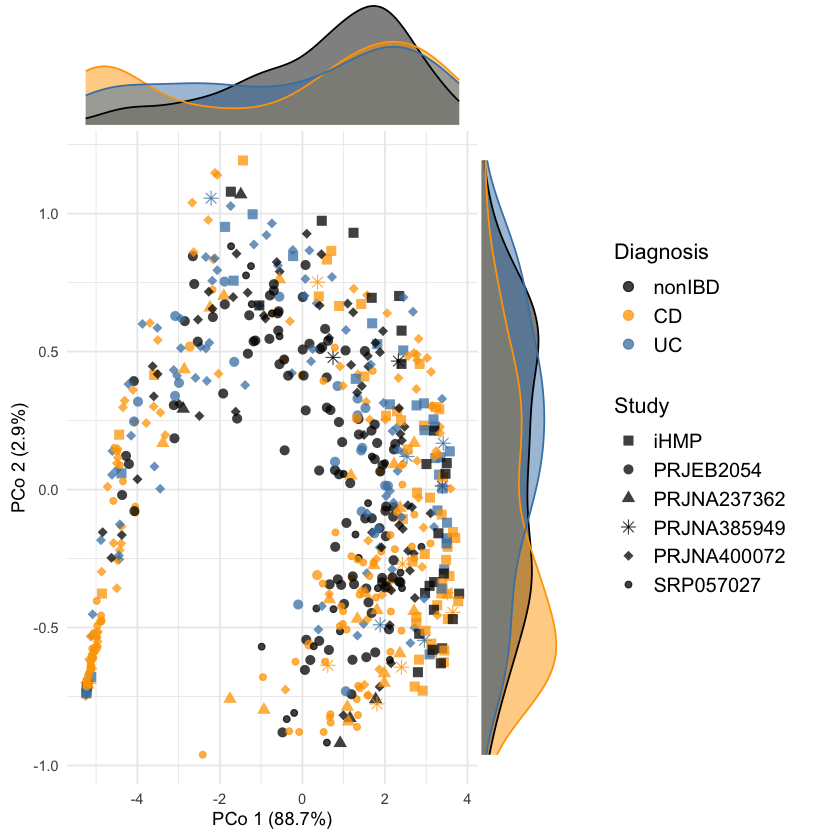

In [23]:
comp_plt_pca_final

### fastp lib nums

In [25]:
sgc_fastp <- read_tsv("outputs/sgc_genome_queries_fastp/all_fastp.tsv", show_col_types = F) %>%
  mutate(mean_read_length = mean(general.after_filtering_read1_mean_length + general.after_filtering_read2_mean_length, na.rm = T),
         sgc_basepairs = general.before_filtering_total_reads * mean_read_length) %>%
  select(library_name, accession, sgc_nbhd_reads = general.before_filtering_total_reads, sgc_basepairs) %>%
  filter(accession == acc_string2)

In [26]:
abundtrim_fastp <- load_multiqc("outputs/fastp_abundtrim/multiqc_data/multiqc_data.json") %>%
  mutate(library_name = gsub("\\.abundtrim", "", metadata.sample_id), .before = 1) %>%
  select(library_name, abundtrim_reads = general.before_filtering_total_reads)

In [27]:
all_fastp <- left_join(sgc_fastp, abundtrim_fastp) %>%
  mutate(fraction_of_metagenome = sgc_nbhd_reads/abundtrim_reads) %>%
  left_join(metadata)

Joining, by = "library_name"
Joining, by = "library_name"


In [28]:
all_fastp <- all_fastp[order(match(all_fastp$library_name, colnames(comp))), ]
all_fastp$plot_order <- 1:nrow(all_fastp)
frac_mgx <- ggplot(all_fastp, aes(y = reorder(library_name, plot_order), x = fraction_of_metagenome, fill= diagnosis)) +
  geom_col() +
  scale_fill_manual(values = c("black", "orange", "steelblue"), name = "Diagnosis") + 
  labs(x = "fraction of mgx") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank())

In [29]:
bps <- ggplot(all_fastp, aes(y =  reorder(library_name, plot_order), x = sgc_basepairs, fill = diagnosis)) +
  geom_col() +
  scale_fill_manual(values = c("black", "orange", "steelblue"), name = "Diagnosis") + 
  labs(x = "base pairs") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank())

In [30]:
comp_melted <- reshape2::melt(comp)
tmp <- ggplot(data = comp_melted, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile() +
  scale_fill_gradient2(low = "#fffed4", mid = "#3aadbd",  high = "#0a1a4b",
                       midpoint = .5, limit = c(0, 1)) +
  labs(x = "library name", y = "library name", fill = "Jaccard\nsimilarity") +
  theme(axis.text = element_blank(), 
        axis.title.x = element_blank(),
        axis.ticks = element_blank())

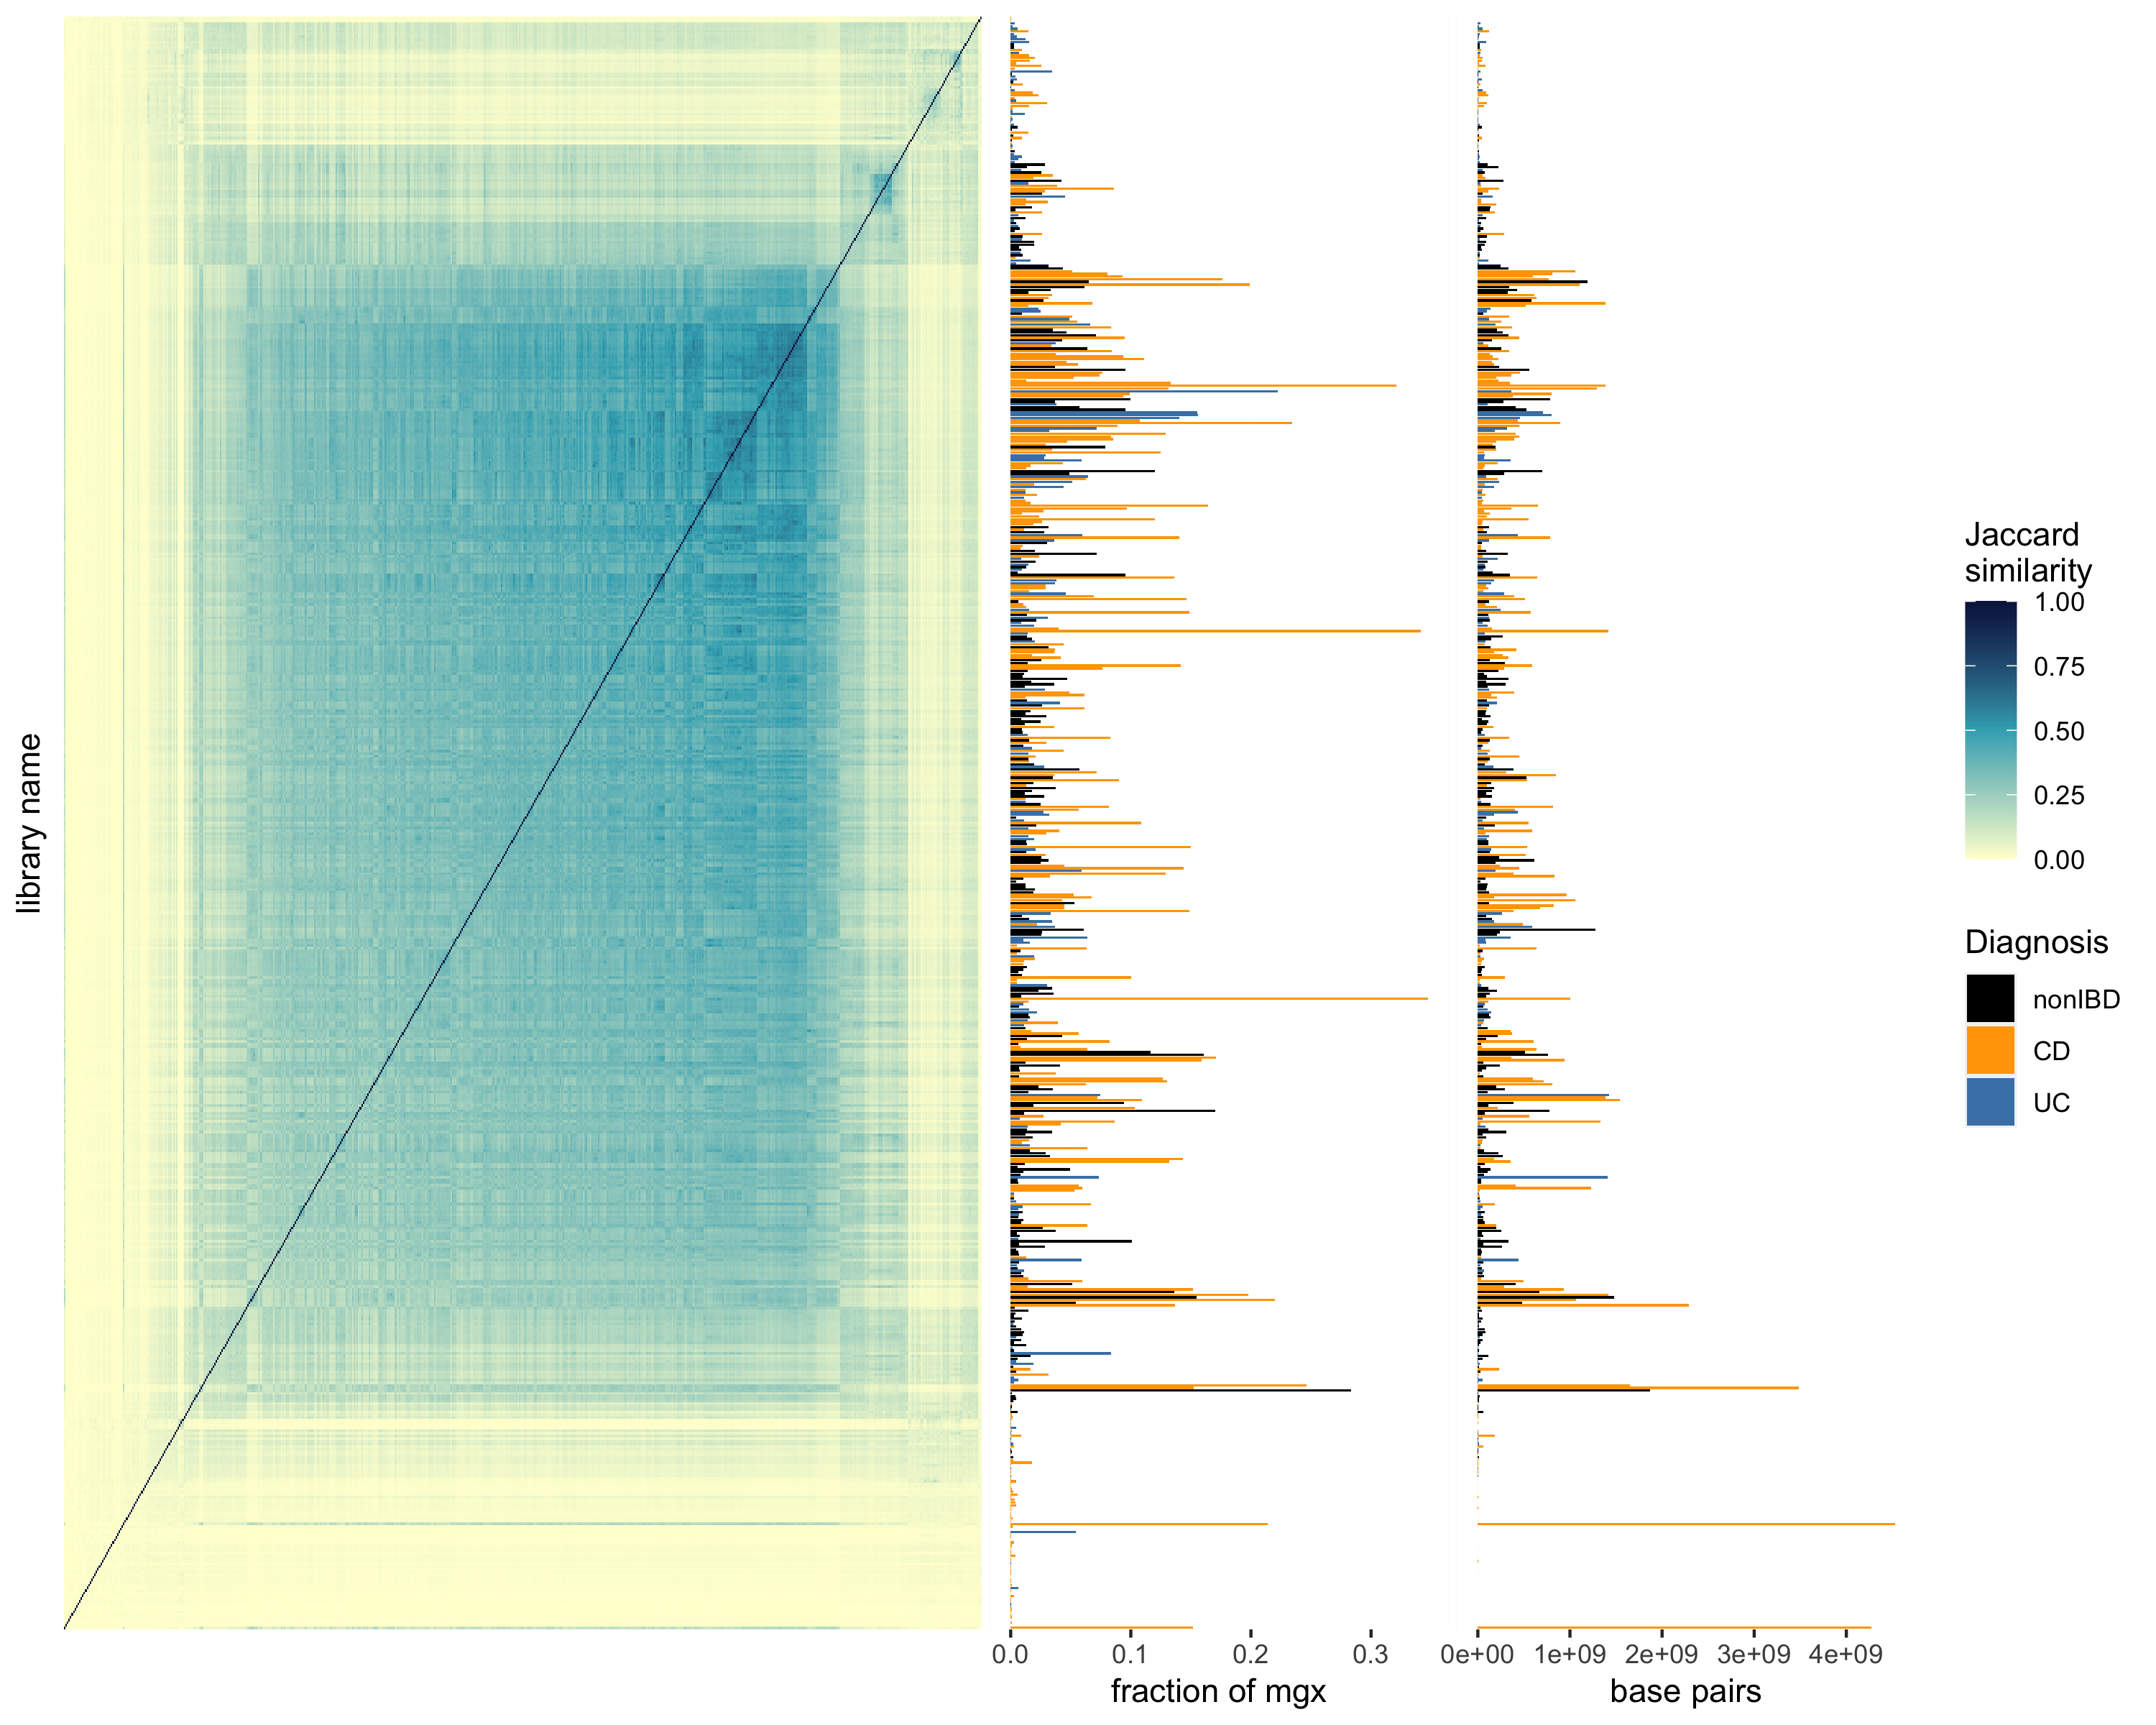

In [32]:
# adjust plot size rendered inline
options(repr.plot.width =10, repr.plot.height = 8, repr.plot.res = 300)
frac_mgx %>% insert_left(tmp, width = 2) %>% insert_right(bps)